#**PREDICTING ENERGY CONSUMPTION USING SMART METERS IN LONDON**

## **DATA GATHERING**

In [257]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [258]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/smart-meters-in-london/') #/smart-meters-in-london/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Load houses with energy data**

In [263]:
# merge the data of 112 blocks present in 112 files
file_combined = open("houses_and_energy.csv", "a")

for lines in open("./daily_dataset/block_0.csv"):
  file_combined.write(lines)

for block in range(0,112):
  file = open("./daily_dataset/block_"+str(block)+".csv")
  file.readline()
  for lines in file:
    file_combined.write(lines)
  file.close()
file_combined.close() 

In [264]:
#load the data into dataframe
houses_and_energy = pd.read_csv('houses_and_energy.csv')
houses_and_energy.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46,0.196034,7.098,0.000
1,MAC000002,2012-10-13,0.1800,0.230979,0.933,48,0.192329,11.087,0.076
2,MAC000002,2012-10-14,0.1580,0.275479,1.085,48,0.274647,13.223,0.070
3,MAC000002,2012-10-15,0.1310,0.213688,1.164,48,0.224483,10.257,0.070
4,MAC000002,2012-10-16,0.1450,0.203521,0.991,48,0.184115,9.769,0.087


In [265]:
houses_and_energy.shape

(3536007, 9)

**Load the weather information**

In [266]:
weather_df = pd.read_csv("weather_daily_darksky.csv")
weather_df.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,rain,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 00:00:00,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,rain,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 00:00:00,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,10.33,rain,13.39,0.74,2011-12-27 14:00:00,5.52,10.33,0.0,2011-12-27 00:00:00,2011-12-27 15:57:56,8.03,8.03,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,5.33,rain,11.89,0.87,2011-12-02 12:00:00,3.26,5.33,1.0,2011-12-02 00:00:00,2011-12-02 15:56:17,6.33,2.56,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,5.02,rain,13.16,0.80,2011-12-24 15:00:00,4.37,5.32,1.0,2011-12-24 00:00:00,2011-12-24 15:55:55,7.45,3.17,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [267]:
weather_df.shape

(882, 32)

**Load the Bank holidays data**

In [268]:
bank_holidays_df = pd.read_csv("uk_bank_holidays.csv")
bank_holidays_df.head()

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [269]:
bank_holidays_df.shape

(25, 2)

## **DATA PRE-PROCESSING**

In [270]:
#taking house ID, day and sum of the energy consumed for analysis
houses_and_energy = houses_and_energy[['LCLid','day','energy_sum']]
houses_and_energy.head()

,LCLid,day,energy_sum
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [271]:
#grouping the data by day and adding the energy consumed for each day
energy_df = houses_and_energy.groupby('day')[['energy_sum']].sum()
energy_df.head()

,energy_sum
day,
2011-11-23,90.385000
2011-11-24,213.412000
2011-11-25,303.993000
2011-11-26,420.976000
2011-11-27,444.883001


In [272]:
#count the number of household for each day
houses_and_energy = houses_and_energy.groupby('day')[['LCLid']].nunique()
houses_and_energy.head()

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41
2011-11-27,41


In [273]:
#day, number of households and sum of energy consumed is taken for analysis
houses_and_energy = houses_and_energy.merge(energy_df, on='day')
houses_and_energy.reset_index(inplace=True)
houses_and_energy.head()

,day,LCLid,energy_sum
0,2011-11-23,13,90.385000
1,2011-11-24,25,213.412000
2,2011-11-25,32,303.993000
3,2011-11-26,41,420.976000
4,2011-11-27,41,444.883001


In [274]:
#change the datatype of day

houses_and_energy.day = pd.to_datetime(houses_and_energy.day,format='%Y-%m-%d').dt.date

#add energy_avg column to compute average energy consumed on a particular day
houses_and_energy['energy_avg'] = houses_and_energy['energy_sum']/houses_and_energy['LCLid']
houses_and_energy.head()

,day,LCLid,energy_sum,energy_avg
0,2011-11-23,13,90.385000,6.952692
1,2011-11-24,25,213.412000,8.536480
2,2011-11-25,32,303.993000,9.499781
3,2011-11-26,41,420.976000,10.267707
4,2011-11-27,41,444.883001,10.850805


In [275]:
#creating 'day' column so that weather_df can be easily merged with houses_and_energy_df
weather_df['day'] = pd.to_datetime(weather_df.time)
weather_df['day'] = pd.to_datetime(weather_df['day'], format="%Y-%m-%d").dt.date
weather_df.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,day
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,rain,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 00:00:00,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52,2011-11-11
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,rain,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 00:00:00,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53,2011-12-11
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,10.33,rain,13.39,0.74,2011-12-27 14:00:00,5.52,10.33,0.0,2011-12-27 00:00:00,2011-12-27 15:57:56,8.03,8.03,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10,2011-12-27
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,5.33,rain,11.89,0.87,2011-12-02 12:00:00,3.26,5.33,1.0,2011-12-02 00:00:00,2011-12-02 15:56:17,6.33,2.56,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25,2011-12-02
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,5.02,rain,13.16,0.80,2011-12-24 15:00:00,4.37,5.32,1.0,2011-12-24 00:00:00,2011-12-24 15:55:55,7.45,3.17,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99,2011-12-24


In [276]:
#choosing only the columns we are going to use for analysis
weather_df = weather_df.drop(columns=['icon', 'summary', 'precipType'])
weather_df.head()

,temperatureMax,temperatureMaxTime,windBearing,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,day
0,11.96,2011-11-11 23:00:00,123,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 00:00:00,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52,2011-11-11
1,8.59,2011-12-11 14:00:00,198,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 00:00:00,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53,2011-12-11
2,10.33,2011-12-27 02:00:00,225,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,10.33,13.39,0.74,2011-12-27 14:00:00,5.52,10.33,0.0,2011-12-27 00:00:00,2011-12-27 15:57:56,8.03,8.03,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10,2011-12-27
3,8.07,2011-12-02 23:00:00,232,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,5.33,11.89,0.87,2011-12-02 12:00:00,3.26,5.33,1.0,2011-12-02 00:00:00,2011-12-02 15:56:17,6.33,2.56,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25,2011-12-02
4,8.22,2011-12-24 23:00:00,252,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,5.02,13.16,0.80,2011-12-24 15:00:00,4.37,5.32,1.0,2011-12-24 00:00:00,2011-12-24 15:55:55,7.45,3.17,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99,2011-12-24


In [277]:
#converting the bank holidays column to date type
bank_holidays_df['Bank holidays'] = pd.to_datetime(bank_holidays_df['Bank holidays'], format="%Y-%m-%d").dt.date
bank_holidays_df.rename(columns={'Bank holidays':'day'}, inplace=True)
bank_holidays_df.head()

,day,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


**MERGING** **DATAFRAMES**

In [278]:
#combine houses and energy data with weather data
master_df = houses_and_energy.merge(weather_df, on='day')
master_df.head()

,day,LCLid,energy_sum,energy_avg,temperatureMax,temperatureMaxTime,windBearing,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,2011-11-23,13,90.385000,6.952692,10.36,2011-11-23 14:00:00,229,6.29,2011-11-23 07:00:00,0.36,2.04,1027.12,2011-11-23 07:00:00,10.36,8.06,0.93,2011-11-23 14:00:00,6.56,10.36,1.0,2011-11-23 00:00:00,2011-11-23 16:03:50,8.24,3.81,10.36,2011-11-23 07:32:38,2011-11-23 14:00:00,2011-11-23 10:00:00,2011-11-23 22:00:00,2.18,2011-11-23 14:00:00,2011-11-23 22:00:00,0.94
1,2011-11-24,25,213.412000,8.536480,12.93,2011-11-24 12:00:00,204,8.56,2011-11-24 02:00:00,0.41,4.04,1027.22,2011-11-24 02:00:00,12.93,10.64,0.89,2011-11-24 12:00:00,7.30,12.93,1.0,2011-11-24 00:00:00,2011-11-24 16:02:48,9.71,8.56,12.93,2011-11-24 07:34:14,2011-11-24 12:00:00,2011-11-24 10:00:00,2011-11-24 19:00:00,7.01,2011-11-24 12:00:00,2011-11-24 19:00:00,0.97
2,2011-11-25,32,303.993000,9.499781,13.03,2011-11-25 05:00:00,243,7.24,2011-11-25 23:00:00,0.48,5.02,1024.47,2011-11-25 23:00:00,12.27,12.38,0.79,2011-11-25 12:00:00,4.69,13.03,1.0,2011-11-25 00:00:00,2011-11-25 16:01:49,7.01,7.46,12.27,2011-11-25 07:35:49,2011-11-25 12:00:00,2011-11-25 10:00:00,2011-11-26 01:00:00,4.84,2011-11-25 05:00:00,2011-11-26 05:00:00,0.01
3,2011-11-26,41,420.976000,10.267707,12.96,2011-11-26 14:00:00,237,6.96,2011-11-26 01:00:00,0.44,5.75,1025.80,2011-11-26 05:00:00,12.96,13.07,0.81,2011-11-26 14:00:00,11.59,12.96,1.0,2011-11-26 00:00:00,2011-11-26 16:00:53,11.59,7.01,12.96,2011-11-26 07:37:22,2011-11-26 14:00:00,2011-11-26 10:00:00,2011-11-26 23:00:00,4.69,2011-11-26 14:00:00,2011-11-26 23:00:00,0.05
4,2011-11-27,41,444.883001,10.850805,13.54,2011-11-27 10:00:00,256,5.76,2011-11-27 23:00:00,0.42,5.48,1021.11,2011-11-27 23:00:00,13.54,13.08,0.72,2011-11-27 10:00:00,1.31,13.54,1.0,2011-11-27 00:00:00,2011-11-27 16:00:00,1.31,4.47,13.54,2011-11-27 07:38:54,2011-11-27 10:00:00,2011-11-27 10:00:00,2011-11-28 05:00:00,2.94,2011-11-27 10:00:00,2011-11-28 05:00:00,0.08


In [279]:
master_df.shape

(829, 33)

In [280]:
#combine the master data created in the previous step with bank holidays data
master_df = master_df.merge(bank_holidays_df, on='day', how='left')
master_df.shape

(829, 34)

In [281]:
#Adding an indicator to know whether a particular day is holiday or not
master_df['is_a_holiday'] = np.where(master_df['Type'].isna(),0,1)
master_df['Type'].fillna('not-a-holiday', inplace=True)
master_df.head()

,day,LCLid,energy_sum,energy_avg,temperatureMax,temperatureMaxTime,windBearing,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Type,is_a_holiday
0,2011-11-23,13,90.385000,6.952692,10.36,2011-11-23 14:00:00,229,6.29,2011-11-23 07:00:00,0.36,2.04,1027.12,2011-11-23 07:00:00,10.36,8.06,0.93,2011-11-23 14:00:00,6.56,10.36,1.0,2011-11-23 00:00:00,2011-11-23 16:03:50,8.24,3.81,10.36,2011-11-23 07:32:38,2011-11-23 14:00:00,2011-11-23 10:00:00,2011-11-23 22:00:00,2.18,2011-11-23 14:00:00,2011-11-23 22:00:00,0.94,not-a-holiday,0
1,2011-11-24,25,213.412000,8.536480,12.93,2011-11-24 12:00:00,204,8.56,2011-11-24 02:00:00,0.41,4.04,1027.22,2011-11-24 02:00:00,12.93,10.64,0.89,2011-11-24 12:00:00,7.30,12.93,1.0,2011-11-24 00:00:00,2011-11-24 16:02:48,9.71,8.56,12.93,2011-11-24 07:34:14,2011-11-24 12:00:00,2011-11-24 10:00:00,2011-11-24 19:00:00,7.01,2011-11-24 12:00:00,2011-11-24 19:00:00,0.97,not-a-holiday,0
2,2011-11-25,32,303.993000,9.499781,13.03,2011-11-25 05:00:00,243,7.24,2011-11-25 23:00:00,0.48,5.02,1024.47,2011-11-25 23:00:00,12.27,12.38,0.79,2011-11-25 12:00:00,4.69,13.03,1.0,2011-11-25 00:00:00,2011-11-25 16:01:49,7.01,7.46,12.27,2011-11-25 07:35:49,2011-11-25 12:00:00,2011-11-25 10:00:00,2011-11-26 01:00:00,4.84,2011-11-25 05:00:00,2011-11-26 05:00:00,0.01,not-a-holiday,0
3,2011-11-26,41,420.976000,10.267707,12.96,2011-11-26 14:00:00,237,6.96,2011-11-26 01:00:00,0.44,5.75,1025.80,2011-11-26 05:00:00,12.96,13.07,0.81,2011-11-26 14:00:00,11.59,12.96,1.0,2011-11-26 00:00:00,2011-11-26 16:00:53,11.59,7.01,12.96,2011-11-26 07:37:22,2011-11-26 14:00:00,2011-11-26 10:00:00,2011-11-26 23:00:00,4.69,2011-11-26 14:00:00,2011-11-26 23:00:00,0.05,not-a-holiday,0
4,2011-11-27,41,444.883001,10.850805,13.54,2011-11-27 10:00:00,256,5.76,2011-11-27 23:00:00,0.42,5.48,1021.11,2011-11-27 23:00:00,13.54,13.08,0.72,2011-11-27 10:00:00,1.31,13.54,1.0,2011-11-27 00:00:00,2011-11-27 16:00:00,1.31,4.47,13.54,2011-11-27 07:38:54,2011-11-27 10:00:00,2011-11-27 10:00:00,2011-11-28 05:00:00,2.94,2011-11-27 10:00:00,2011-11-28 05:00:00,0.08,not-a-holiday,0


###**DATA CLEANING**

In [282]:
master_df.describe()

,LCLid,energy_sum,energy_avg,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,is_a_holiday
count,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,828.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,828.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000
mean,4229.575392,43483.533803,10.492235,13.680543,197.945718,6.544753,0.479638,3.606273,1014.034946,12.700217,11.296767,0.780531,6.134415,12.913329,2.591787,7.763257,7.453209,13.558432,5.766743,0.500796,0.021713
std,1792.713041,20572.436054,1.902396,6.332020,89.062878,4.917198,0.191571,1.712262,11.127844,7.460024,2.320175,0.094711,6.154799,7.282502,1.866793,4.962144,4.984435,6.411557,6.173678,0.288515,0.145832
min,13.000000,90.385000,0.211766,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000,0.000000
25%,3998.000000,34511.508999,8.676955,9.320000,130.000000,3.110000,0.350000,2.370000,1007.400000,6.610000,10.540000,0.720000,1.430000,7.170000,1.000000,3.980000,3.640000,9.100000,1.070000,0.250000,0.000000
50%,5132.000000,46615.742000,10.527709,12.570000,221.000000,6.440000,0.470000,3.480000,1014.410000,12.410000,12.040000,0.790000,5.370000,12.570000,2.000000,7.540000,7.060000,12.410000,4.890000,0.500000,0.000000
75%,5369.000000,59755.616996,12.000690,18.090000,256.000000,10.220000,0.600000,4.600000,1021.600000,18.080000,12.860000,0.850000,11.650000,18.120000,4.000000,11.650000,11.460000,18.080000,11.460000,0.750000,0.000000
max,5541.000000,84156.135002,15.964434,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000,1.000000


**Handling missing values**

In [283]:
#finding which column has missing values
master_df.isna().sum()

day                            0
LCLid                          0
energy_sum                     0
energy_avg                     0
temperatureMax                 0
temperatureMaxTime             0
windBearing                    0
dewPoint                       0
temperatureMinTime             0
cloudCover                     1
windSpeed                      0
pressure                       0
apparentTemperatureMinTime     0
apparentTemperatureHigh        0
visibility                     0
humidity                       0
apparentTemperatureHighTime    0
apparentTemperatureLow         0
apparentTemperatureMax         0
uvIndex                        1
time                           0
sunsetTime                     0
temperatureLow                 0
temperatureMin                 0
temperatureHigh                0
sunriseTime                    0
temperatureHighTime            0
uvIndexTime                    1
temperatureLowTime             0
apparentTemperatureMin         0
apparentTe

It looks like cloud cover, UV index and UV index time has missing values.

In [284]:
#check the number of records before dropping missing values
len(master_df)

829

In [285]:
#drop the missing records
master_df.dropna(inplace=True)

In [286]:
#check whether the missing record has been dropped
len(master_df)

828

**Handling duplicate values**

In [287]:
#number of unique days for which the data is present
print(master_df.day.nunique())

826


In [288]:
#total number of records present in the dataframe
len(master_df.day)

828

We can see that there are 2 duplicate records in the dataframe.

In [289]:
#check whether a record for a particular day is duplicated or not
master_df[master_df.day.duplicated() == True]

,day,LCLid,energy_sum,energy_avg,temperatureMax,temperatureMaxTime,windBearing,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Type,is_a_holiday
124,2012-03-25,1189,12814.888002,10.777870,13.79,2012-03-25 15:00:00,70,4.69,2012-03-25 06:00:00,0.39,2.58,1033.50,2012-03-25 07:00:00,13.79,9.00,0.78,2012-03-25 15:00:00,2.40,13.79,3.0,2012-03-25 00:00:00,2012-03-25 18:22:58,3.84,4.40,13.79,2012-03-25 05:52:04,2012-03-25 15:00:00,2012-03-25 12:00:00,2012-03-26 05:00:00,2.47,2012-03-25 15:00:00,2012-03-26 05:00:00,0.09,not-a-holiday,0
495,2013-03-31,5410,65729.952009,12.149714,4.96,2013-03-31 13:00:00,67,-3.57,2013-03-31 05:00:00,0.40,2.80,1014.56,2013-03-31 21:00:00,1.64,12.67,0.68,2013-03-31 13:00:00,-2.38,1.64,3.0,2013-03-31 00:00:00,2013-03-31 18:32:31,1.10,-1.54,4.96,2013-03-31 05:38:55,2013-03-31 13:00:00,2013-03-31 12:00:00,2013-03-31 23:00:00,-2.33,2013-03-31 13:00:00,2013-04-01 02:00:00,0.65,not-a-holiday,0


In [290]:
master_df.iloc[123:125]

,day,LCLid,energy_sum,energy_avg,temperatureMax,temperatureMaxTime,windBearing,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Type,is_a_holiday
123,2012-03-25,1189,12814.888002,10.77787,18.18,2012-03-26 14:00:00,77,4.30,2012-03-26 05:00:00,0.15,2.85,1036.22,2012-03-26 05:00:00,18.18,8.16,0.71,2012-03-26 14:00:00,4.77,18.18,3.0,2012-03-25 23:00:00,2012-03-26 18:24:38,5.32,3.84,18.18,2012-03-26 05:49:47,2012-03-26 14:00:00,2012-03-26 11:00:00,2012-03-27 05:00:00,2.40,2012-03-26 14:00:00,2012-03-27 06:00:00,0.12,not-a-holiday,0
124,2012-03-25,1189,12814.888002,10.77787,13.79,2012-03-25 15:00:00,70,4.69,2012-03-25 06:00:00,0.39,2.58,1033.50,2012-03-25 07:00:00,13.79,9.00,0.78,2012-03-25 15:00:00,2.40,13.79,3.0,2012-03-25 00:00:00,2012-03-25 18:22:58,3.84,4.40,13.79,2012-03-25 05:52:04,2012-03-25 15:00:00,2012-03-25 12:00:00,2012-03-26 05:00:00,2.47,2012-03-25 15:00:00,2012-03-26 05:00:00,0.09,not-a-holiday,0


In [291]:
master_df.iloc[494:498]

,day,LCLid,energy_sum,energy_avg,temperatureMax,temperatureMaxTime,windBearing,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Type,is_a_holiday
494,2013-03-31,5410,65729.952009,12.149714,5.88,2013-04-01 15:00:00,68,-3.45,2013-03-31 23:00:00,0.57,5.50,1011.52,2013-04-01 22:00:00,1.29,12.68,0.64,2013-04-01 15:00:00,-4.26,1.29,3.0,2013-03-31 23:00:00,2013-04-01 18:34:11,0.04,1.10,5.88,2013-04-01 05:36:38,2013-04-01 15:00:00,2013-04-01 11:00:00,2013-04-02 05:00:00,-3.14,2013-04-01 15:00:00,2013-04-02 05:00:00,0.68,not-a-holiday,0
495,2013-03-31,5410,65729.952009,12.149714,4.96,2013-03-31 13:00:00,67,-3.57,2013-03-31 05:00:00,0.40,2.80,1014.56,2013-03-31 21:00:00,1.64,12.67,0.68,2013-03-31 13:00:00,-2.38,1.64,3.0,2013-03-31 00:00:00,2013-03-31 18:32:31,1.10,-1.54,4.96,2013-03-31 05:38:55,2013-03-31 13:00:00,2013-03-31 12:00:00,2013-03-31 23:00:00,-2.33,2013-03-31 13:00:00,2013-04-01 02:00:00,0.65,not-a-holiday,0
496,2013-04-01,5405,65887.532002,12.190108,7.71,2013-04-02 15:00:00,54,-4.69,2013-04-02 05:00:00,0.20,5.50,1014.63,2013-04-02 05:00:00,3.74,13.02,0.57,2013-04-02 13:00:00,-3.72,3.74,3.0,2013-04-01 23:00:00,2013-04-02 18:35:51,0.48,0.04,7.71,2013-04-02 05:34:21,2013-04-02 15:00:00,2013-04-02 11:00:00,2013-04-03 05:00:00,-4.26,2013-04-02 13:00:00,2013-04-03 04:00:00,0.72,not-a-holiday,0
497,2013-04-02,5407,61974.851001,11.461966,4.09,2013-04-03 14:00:00,43,-3.70,2013-04-03 05:00:00,0.45,5.84,1017.40,2013-04-03 04:00:00,-0.73,13.10,0.64,2013-04-03 17:00:00,-3.52,-0.57,3.0,2013-04-02 23:00:00,2013-04-03 18:37:31,0.98,0.48,4.09,2013-04-03 05:32:05,2013-04-03 14:00:00,2013-04-03 12:00:00,2013-04-04 04:00:00,-3.72,2013-04-03 20:00:00,2013-04-04 05:00:00,0.76,not-a-holiday,0


While analysing the duplicate values, it can be seen that the 2 duplicated values are observed in 12 AM whereas the other 826 records are recorded in 11PM which is unusual. Hence it is safe to conclude that the 2 duplicated records can be dropped as there might be some error while entering weather data. 

In [292]:
#checking the number of records before dropping duplicate values
master_df.shape

(828, 35)

In [293]:
#drop the duplicate values
master_df.drop_duplicates(subset=['day'],inplace=True)

In [294]:
#checking the number of records after dropping duplicate values
master_df.shape

(826, 35)

In [295]:
#storing the processed data in a csv file
master_df.to_csv("master_df.csv", index=False)

# EDA

Average Energy Consumption per day

In [296]:
# Creating seperate dataframe to get day of the week from the dates

date_df = master_df

In [297]:
# Converting the day column to datetime format and the days are extracted

date_df['day'] = pd.to_datetime(date_df['day'],format='%Y-%m-%d')
date_df['day_of_the_week'] = date_df['day'].dt.day_name()

Text(0, 0.5, 'Average Energy Consumed')

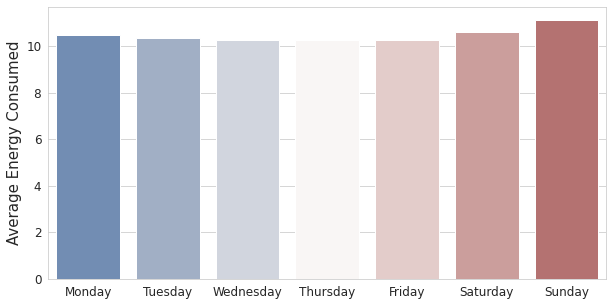

In [298]:
# Bar chart to visualise the average energy consumed per day

plt.rcParams.update({'font.size': 12})
sns.set_style(style="whitegrid")
plt.figure(figsize=(10,5))
week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax = sns.barplot(x='day_of_the_week',y='energy_avg',data=date_df,palette="vlag",order=week,ci=None)
plt.xlabel(None)
plt.ylabel('Average Energy Consumed',size=15)

Exploring the relation between Energy Consumption and Maximum Temperature   


No handles with labels found to put in legend.
No handles with labels found to put in legend.


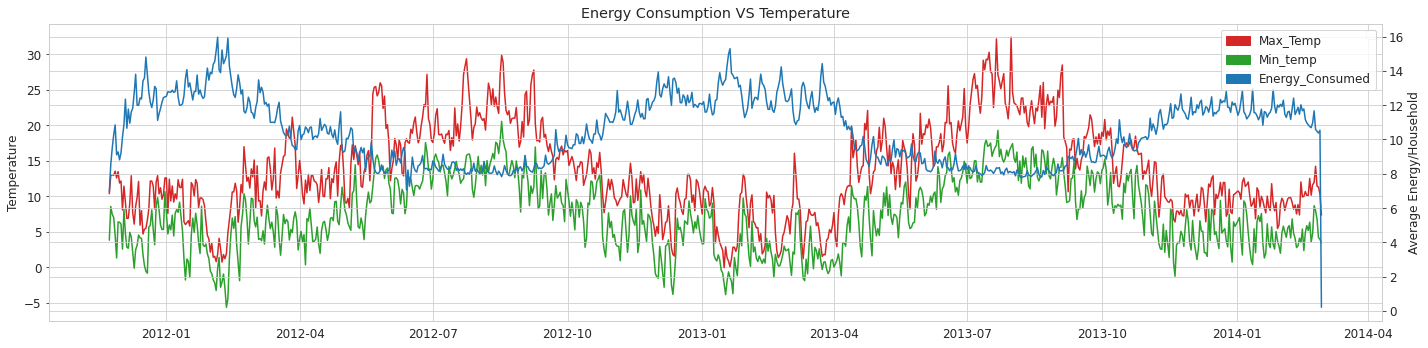

In [299]:
# Dual axis line chart to identify the impact of temperature on energy consumption

fig, ax1 = plt.subplots(figsize = (20,5))
colors = {'Max_Temp':'tab:red','Min_temp':'tab:green','Energy_Consumed':'tab:blue'} 
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax1.plot(master_df.day, master_df.temperatureMax, color = 'tab:red')
ax1.plot(master_df.day, master_df.temperatureMin, color = 'tab:green')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(master_df.day,master_df.energy_avg,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption VS Temperature')
plt.legend(handles, labels,loc="upper right")
fig.tight_layout()
plt.show()

Exploring the relation between Energy Consumption and Wind Speed

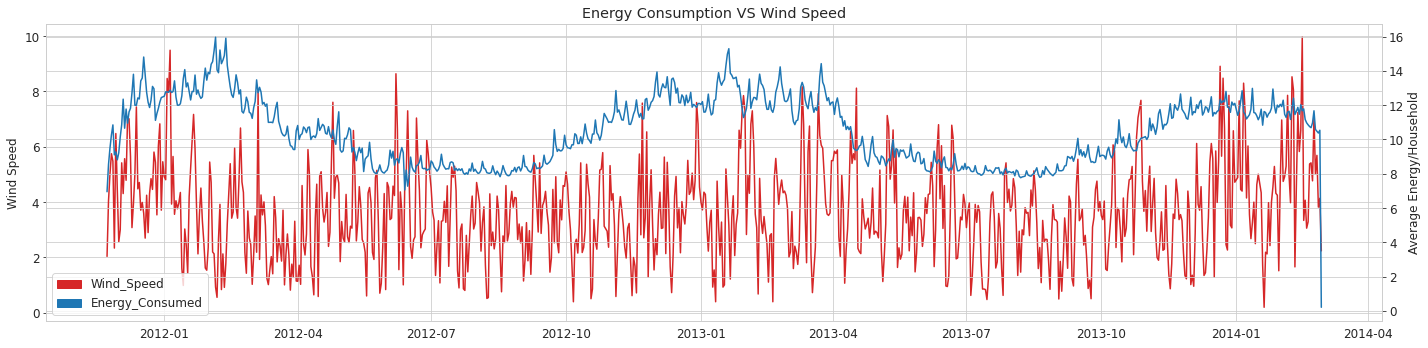

In [300]:
# Dual axis line chart to identify the impact of wind speed on energy consumption

fig, ax1 = plt.subplots(figsize = (20,5))
colors = {'Wind_Speed':'tab:red','Energy_Consumed':'tab:blue'} 
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax1.plot(master_df.day, master_df.windSpeed, color = 'tab:red')
ax1.set_ylabel('Wind Speed')
ax2 = ax1.twinx()
ax2.plot(master_df.day,master_df.energy_avg,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household')
plt.title('Energy Consumption VS Wind Speed')
plt.legend(handles, labels,loc="lower left")
fig.tight_layout()
plt.show()

Correlation between weather features

In [301]:
cor_matrix = master_df[['energy_avg','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()

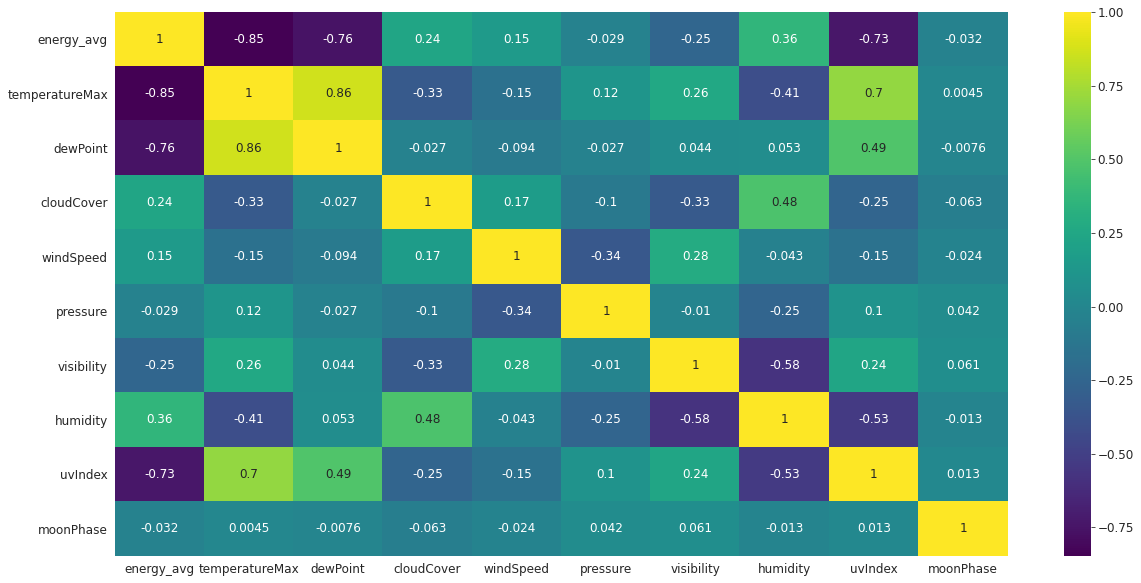

In [302]:
#Heat map to identify correlation between average energy and weather features

plt.figure(figsize=(20,10))
sns.heatmap(cor_matrix,annot=True,cmap='viridis')

K means


In [303]:
# Declaring min max scaler

scaler = MinMaxScaler()

In [304]:
# Scaling and transforming the input features

weather_energy_scaled = scaler.fit_transform(master_df[['temperatureMax','humidity','windSpeed']])

In [305]:
# Iterating K-Means to find optimal number of clusters

score = []
n = range(1,20)
for num in n:
    km = KMeans(n_clusters=num)
    km = km.fit(weather_energy_scaled)
    score.append(km.inertia_)

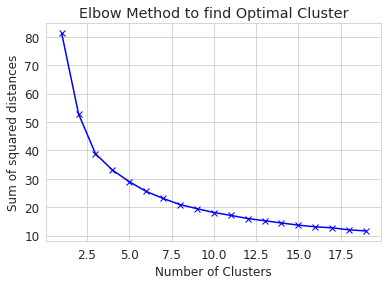

In [306]:
# Plotting elbow chart to find optimal number of clusters

plt.plot(n, score, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method to find Optimal Cluster')
plt.show()

In [307]:
#Fitting the input to K-means model and adding the cluster labels to the main dataframe 

kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_energy_scaled)
master_df['weather_cluster'] = kmeans.labels_

# ML model


In [308]:
master_df['Year'] = pd.DatetimeIndex(master_df['day']).year  
master_df['Month'] = pd.DatetimeIndex(master_df['day']).month
master_df.set_index(['day'],inplace=True)

Subset for 70-30 train & test split

In [309]:
input_model = master_df[['energy_avg','weather_cluster','is_a_holiday']]
train = input_model.iloc[0:(len(input_model)-30)]
test = input_model.iloc[len(train):(len(input_model)-1)]


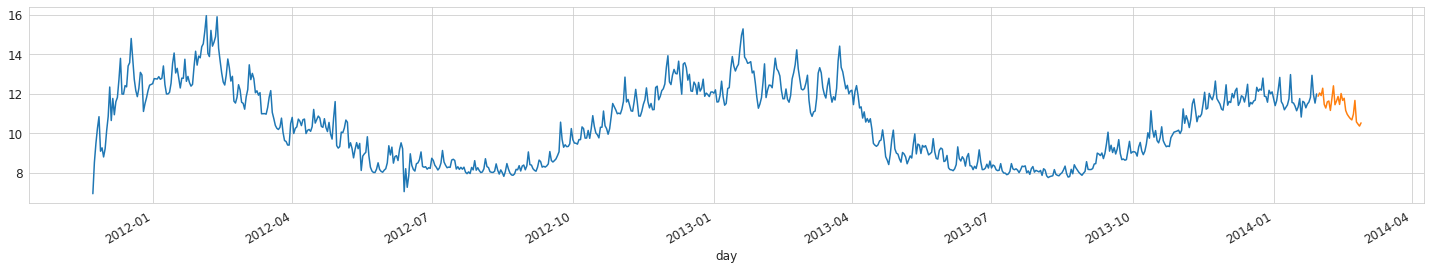

In [310]:
train['energy_avg'].plot(figsize=(25,4))
test['energy_avg'].plot(figsize=(25,4))

In [311]:
test.head()

,energy_avg,weather_cluster,is_a_holiday
day,,,
2014-01-30,11.886982,1,0
2014-01-31,12.051321,1,0
2014-02-01,11.921217,2,0
2014-02-02,12.291726,2,0
2014-02-03,11.471760,2,0


# ACF-PACF


In [312]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

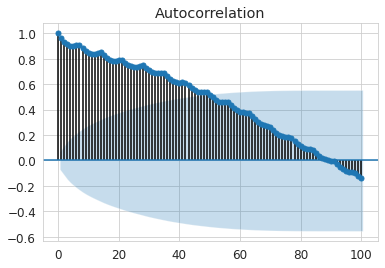

In [313]:
plot_acf(train.energy_avg,lags=100)
plt.show()

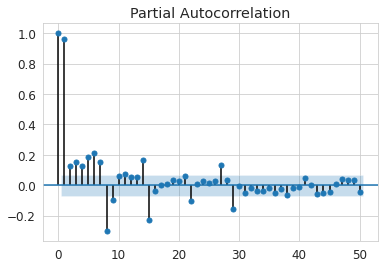

In [314]:
plot_pacf(train.energy_avg,lags=50)
plt.show()

Dickey Fuller's Test


We can say that data is not stationary, since p value is more than 0.05 

In [315]:
t = sm.tsa.adfuller(train.energy_avg, autolag='AIC')
pd.Series(t[0:4], index=['Statistic Test','p value','No of lags','No of obeservations'])

Statistic Test          -1.887767
p value                  0.337837
No of lags              21.000000
No of obeservations    774.000000
dtype: float64

Differencing process

In [316]:
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [317]:
t = sm.tsa.adfuller(difference(train.energy_avg,1), autolag='AIC')
pd.Series(t[0:4], index=['Statistic Test','p value','No of lags','No of obeservations'])

Statistic Test        -6.680971e+00
p value                4.343285e-09
No of lags             2.000000e+01
No of obeservations    7.740000e+02
dtype: float64

Seasonal Decomposition

In [318]:
k = sm.tsa.seasonal_decompose(train.energy_avg,freq=12)

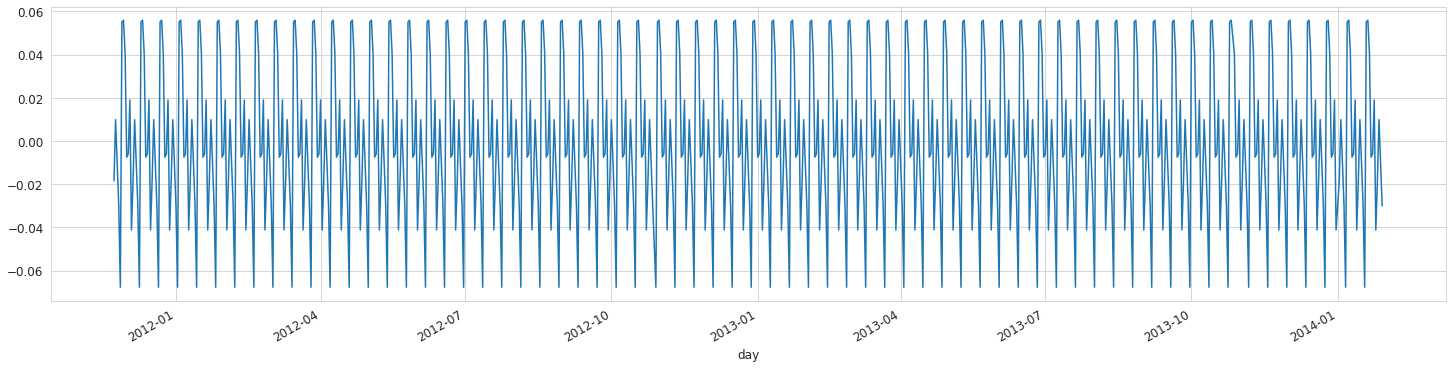

In [319]:
k.seasonal.plot(figsize=(25,6))

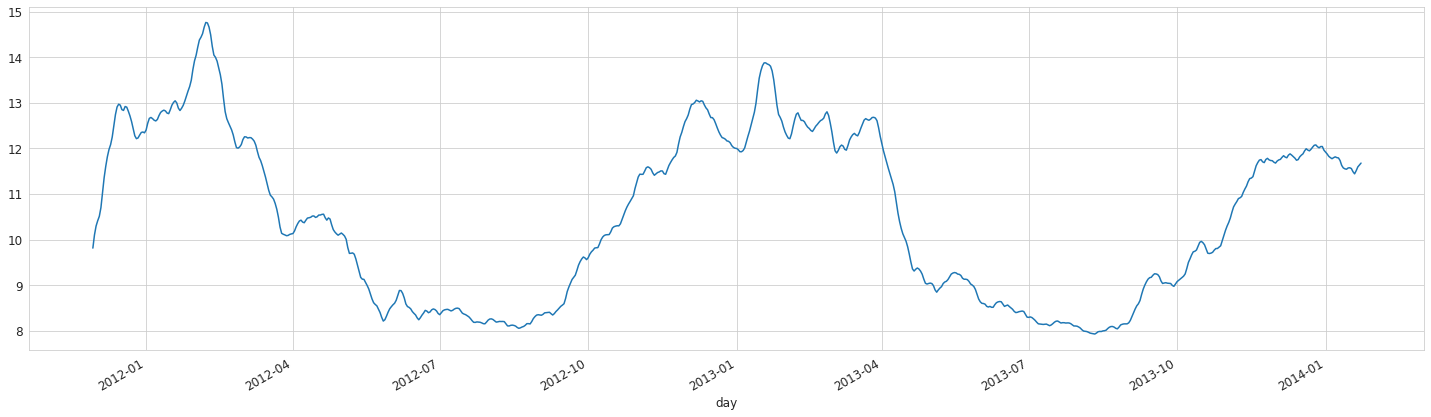

In [320]:
k.trend.plot(figsize=(25,7))

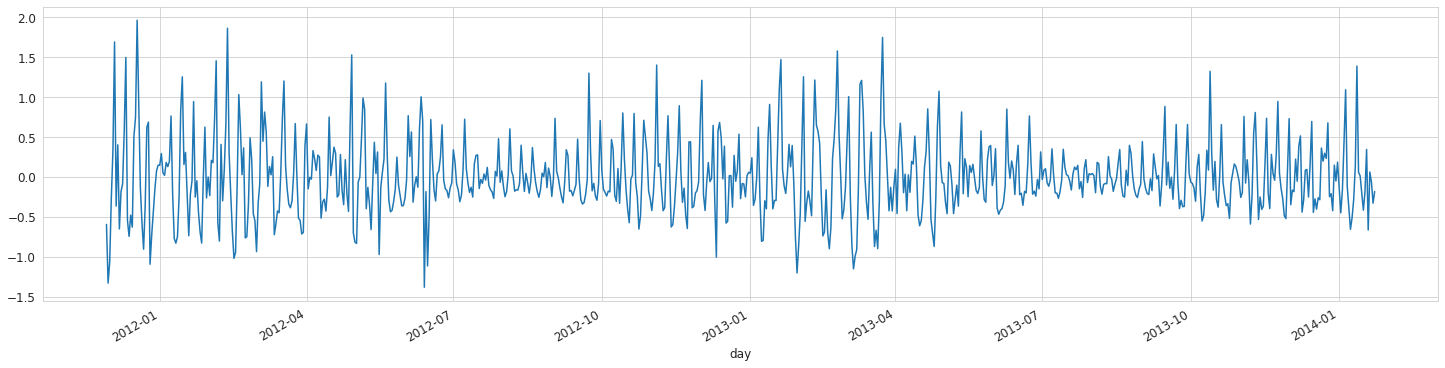

In [321]:
k.resid.plot(figsize=(25,6))

# SARIMAX model


In [322]:
endogeneous_input = train['energy_avg']
exogeneous_input = sm.add_constant(train[['weather_cluster','is_a_holiday']])

model = sm.tsa.statespace.SARIMAX(endog=endogeneous_input, exog=exogeneous_input, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
fit_the_model = model.fit()
fit_the_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         energy_avg   No. Observations:                  796
Model:             SARIMAX(7, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -648.127
Date:                            Thu, 15 Apr 2021   AIC                           1324.254
Time:                                    22:50:54   BIC                           1389.538
Sample:                                         0   HQIC                          1349.359
                                            - 796                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.0065      0.017     -0.382      0.702      -0.040       0.027
const           -2.926e-08   3.45e+05  -8.48e-14      1.000   -6.76e+05    6.76e+05
weather_cluster     0.0049      0.024      0.208      0.835      -0.042       0.051
is_a_holiday       -0.0111      0.088     -0.127      0.899      -0.183       0.160
ar.L1              -0.0116      0.085     -0.136      0.891      -0.179       0.155
ar.L2              -0.1516      0.032     -4.704      0.000      -0.215      -0.088
ar.L3              -0.1388      0.038     -3.687      0.000      -0.213      -0.065
ar.L4              -0.1654      0.038     -4.393      0.000      -0.239      -0.092
ar.L5              -0.1480      0.040     -3.708      0.000      -0.226      -0.070
ar.L6               0.0070      0.035      0.199      0.843      -0.062       0.076
ar.L7               0.3572      0.029     12.433      0.000       0.301       0.414
ma.L1              -0.1790      0.090     -1.988      0.047      -0.355      -0.003
ar.S.L12           -0.4954      0.032    -15.248      0.000      -0.559      -0.432
sigma2              0.3044      0.013     23.938      0.000       0.279       0.329
===================================================================================
Ljung-Box (Q):                      227.28   Jarque-Bera (JB):                41.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  8e+14. Standard errors may be unstable.
"""

Model Fit process

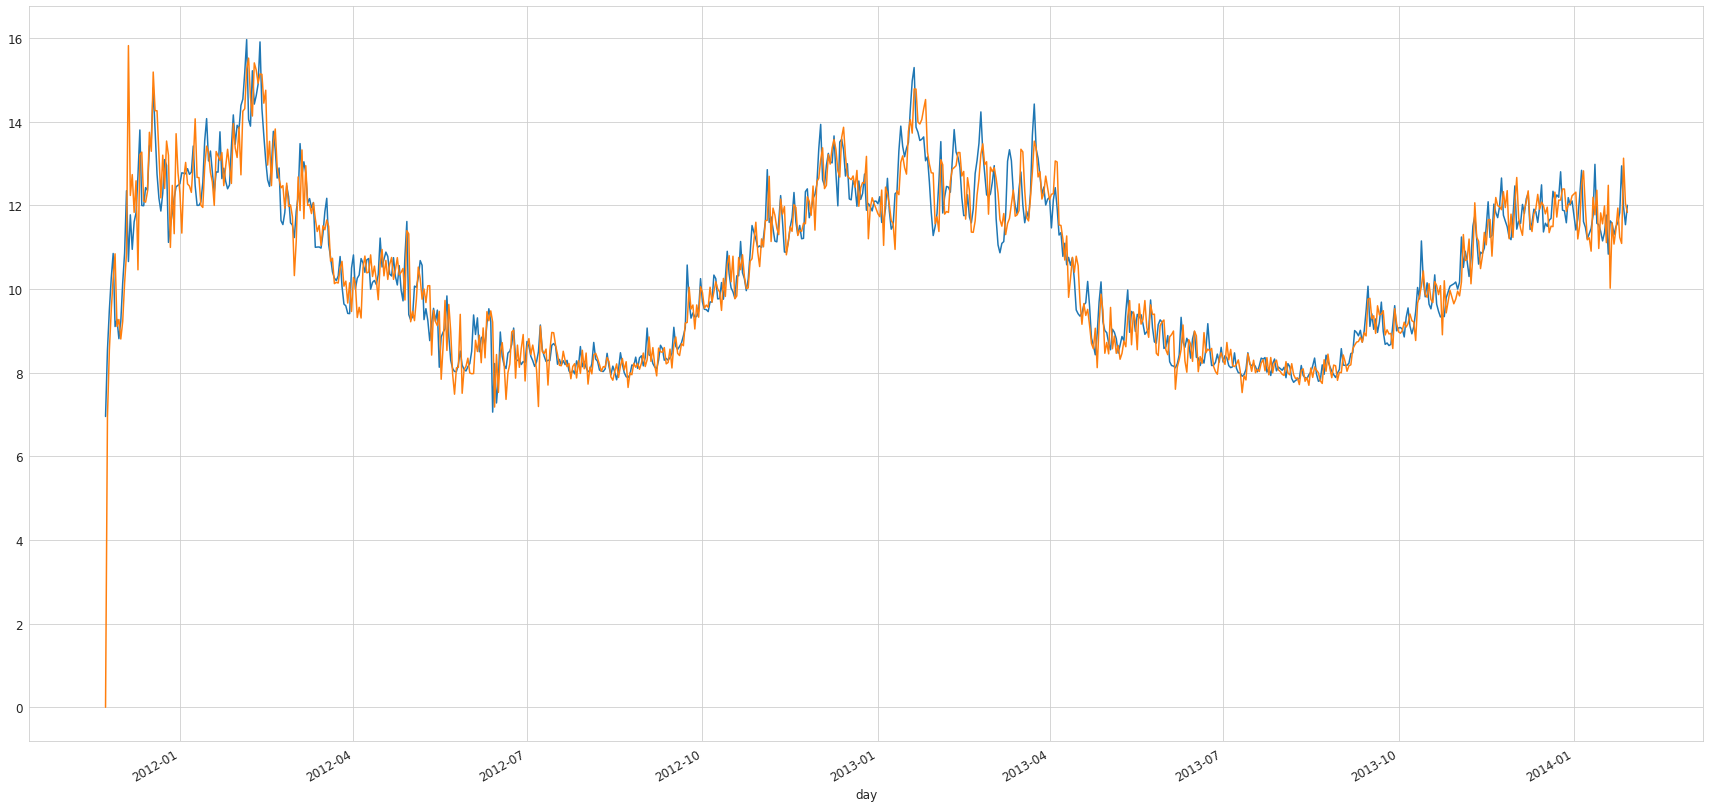

In [323]:
train['energy_avg'].plot(figsize=(30,15))
fit_the_model.fittedvalues.plot()
plt.show()

# Prediction


Prediction

In [324]:
prediction = fit_the_model.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster','is_a_holiday']]))
test['prediction result'] = prediction.values
test.tail(6)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,energy_avg,weather_cluster,is_a_holiday,prediction result
day,,,,
2014-02-22,10.970704,2,0,11.930768
2014-02-23,11.673756,2,0,11.519926
2014-02-24,10.586235,2,0,10.704711
2014-02-25,10.476498,2,0,11.427089
2014-02-26,10.375366,2,0,11.849125
2014-02-27,10.537250,2,0,11.466025


# Model Evaluation using RMSE


Performance -RMSE


In [325]:
#act = [i[9] for i in inv_y] # last element is the predicted average energy
#pred = [i[9] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
rmse = math.sqrt(mean_squared_error(test['energy_avg'], test['prediction result']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.736


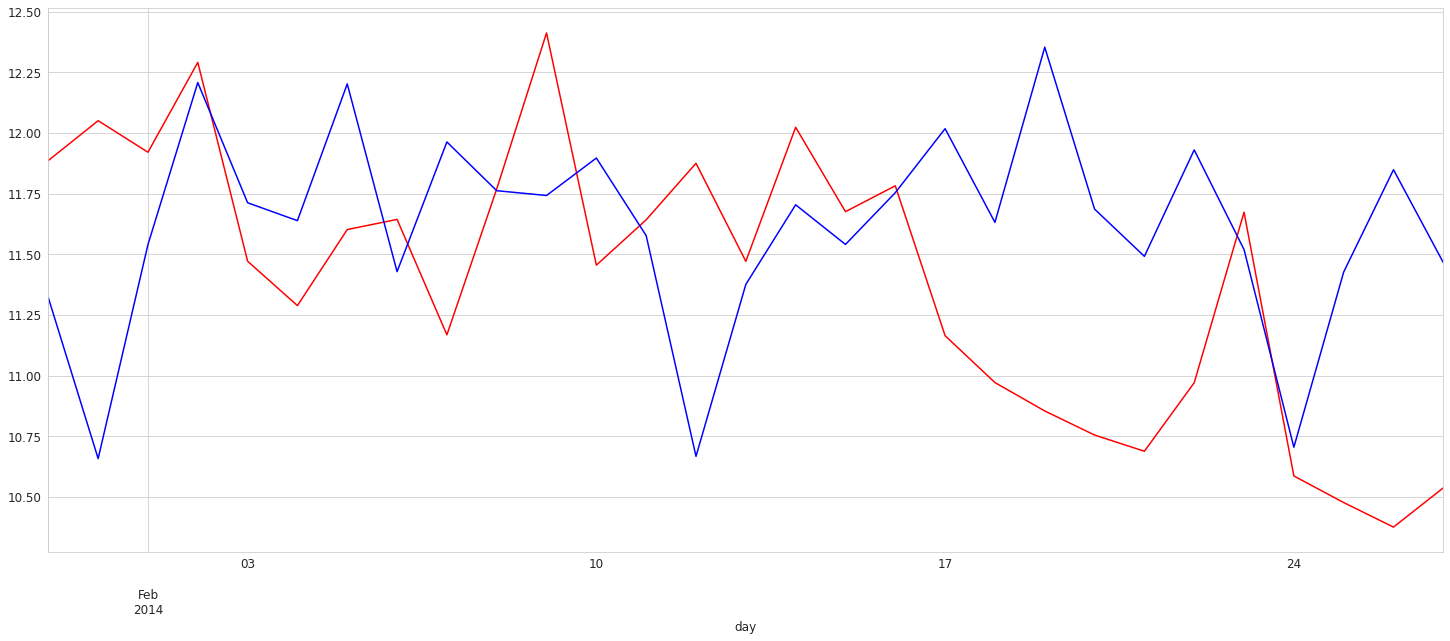

In [326]:
performance_rmse = pd.DataFrame({'predicted':test['prediction result'],'energy_avg':test['energy_avg']})
performance_rmse['energy_avg'].plot(figsize=(25,10),color = 'red')
performance_rmse['predicted'].plot(color = 'blue')
plt.show()